In [1]:
%matplotlib notebook
from NPSmethods2 import readInImages, pupilFunc, getFreq
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from ipywidgets import *

In [2]:
def Mirror(array):
    array2 = np.flip(np.flip(array, 0), 1)
    array2 = np.delete(array2, (0), axis=1)
    array2 = np.delete(array2, (0), axis=1)
    newarray = np.concatenate((array, array2), 1)
        
    return newarray

#Generate M2k_Fit
def make_M2k_Fit(paras, imgSysData):
    
    A, tau, S0, alpha, phi, beta, delta_s = paras
    _, _, K_X, K_Y = getFreq(imgSysData["CCDPixelSize"],
                                      imgSysData["magnification"], (100,100))
    d = imgSysData["wavelen"] / (2*np.pi*imgSysData["NA"])
    R_p, Theta_p = np.abs(K_X + 1j*K_Y) * d, np.angle(K_X + 1j*K_Y)
    p1 = pupilFunc(R_p, Theta_p + np.pi, tau, S0, alpha, phi, beta)
    p2 = np.conj(pupilFunc(R_p, Theta_p, tau, S0, alpha, phi, beta)) * \
            np.exp(-2*1j*delta_s)
    PSF = (p1 + p2) / (2 * np.cos(delta_s))
    M2k = np.abs(PSF)**2
    M2k_Fit = A * M2k
    M2k_Fit[M2k_Fit.shape[0]//2, M2k_Fit.shape[1]//2] = 0
    
#     bkg_noise = np.random.normal(loc=0.026, 
#                                  scale=0.006, 
#                                  size=(100,51))
#     bkg_noise = Mirror(bkg_noise)
#     M2k_Fit[M2k_Fit == 0] += bkg_noise[M2k_Fit == 0]
    
#     bkg_mean = np.mean(M2k_Fit[-11:-1])
#     M2k_Fit -= bkg_mean
    M2k_Fit[M2k_Fit < 0] = 0
    
    return M2k_Fit

imgSysData = { 
    "CCDPixelSize": 13,      # pixel size of the CCD, in micron 
    "magnification": 27,      # 799.943 / 29.9099, # magnification of the imaging system 
    "wavelen"     : 0.852,     # wavelength of the imaging beam, in micron 
    "NA"          : 0.37,      # numerical aperture of the objective 
    "ODtoAtom"    : 13
} 

K_x, K_y, _, _ = getFreq(imgSysData["CCDPixelSize"], imgSysData["magnification"], (100,100))

<IPython.core.display.Javascript object>


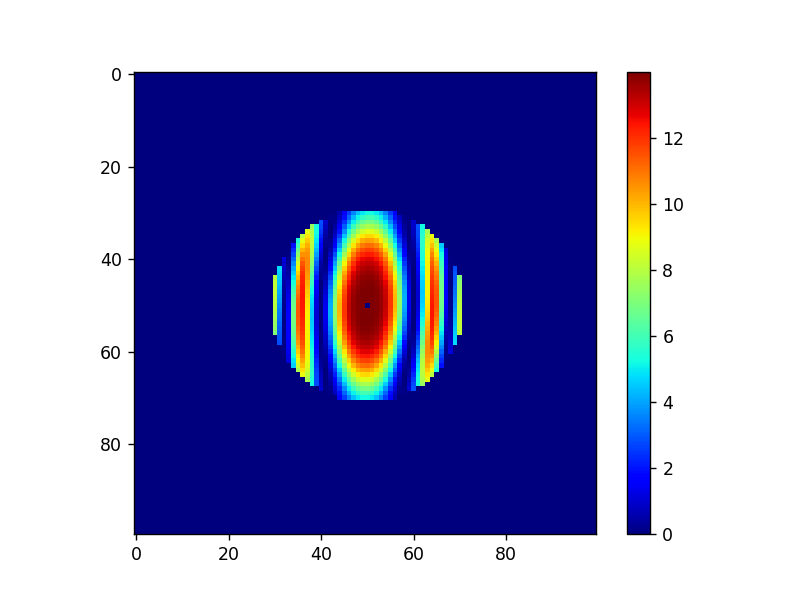

interactive(children=(FloatSlider(value=0.2, description='Amplitude', max=50.0, min=-50.0, step=1.0), FloatSli…

In [3]:
# init_amp = 0.36
# init_decay = 1.78
# init_aberration =  0.02
# init_astigmatism = 1.03      
# init_phi = -1.9
# init_defocus = -.04
# init_detuning = -.06

init_params = [.2, 1.22, .0, 1.24, -1.9,  0.26, 0]

init_amp = init_params[0]
init_decay = init_params[1]
init_aberration = init_params[2]
init_astigmatism = init_params[3]      
init_phi = init_params[4]
init_defocus = init_params[5]
init_detuning = init_params[6]

M2k = make_M2k_Fit([init_amp, 
                    init_decay,
                    init_aberration,
                    init_astigmatism,
                    init_phi, 
                    init_defocus, 
                    init_detuning],
                   imgSysData)
fig = plt.figure()
axs = fig.add_subplot(1,1,1)
im = axs.imshow(#K_x, 
                #K_y, 
                M2k,
                vmax=M2k.max(),
                vmin=0,
                cmap=cm.jet)

fig.colorbar(im)

amp_slider = FloatSlider(
    min=-50,
    max=50,
    step=1,
    value=init_amp,
)

decay_slider = FloatSlider(
    min=0.8,
    max=3,
    step=0.02,
    value=init_decay,
)

aberration_slider = FloatSlider(
    min=-.5,
    max=.5,
    step=0.01,
    value=init_aberration,
)

astigmatism_slider = FloatSlider(
    min=-1.6,
    max=3,
    step=0.01,
    value=init_astigmatism,
)

phi_slider = FloatSlider(
    min=-np.pi,
    max=np.pi,
    step=0.1,
    value=init_phi,
)

defocus_slider = FloatSlider(
    min=-4,
    max=4,
    step=0.02,
    value=init_defocus,
)

detuning_slider = FloatSlider(
    min=-2,
    max=2,
    step=0.1,
    value=init_detuning,
)

def update(Amplitude, Decay, Aberration, Astigmatism, Phi, Defocus, Detuning):
    M2k = make_M2k_Fit([Amplitude,
                        Decay,
                        Aberration, 
                        Astigmatism,
                        Phi, 
                        Defocus, 
                        Detuning],
                       imgSysData)
    im.set_data(M2k)
    im.set_clim(0,M2k.max())
    fig.canvas.draw()

Sliders = interactive(update, 
                      Amplitude=amp_slider, 
                      Decay=decay_slider, 
                      Aberration=aberration_slider, 
                      Astigmatism=astigmatism_slider,
                      Phi=phi_slider,
                      Defocus=defocus_slider,
                      Detuning=detuning_slider)

display(Sliders)